#### download

In [1]:
import os

try:
    os.mkdir("images")
    os.mkdir("images/dogs")
    os.mkdir("images/cats")
except:
    pass

In [2]:
!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs

--2021-02-04 17:24:37--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.130.166, 151.101.194.166, 151.101.2.166, ...
접속 i.kinja-img.com (i.kinja-img.com)|151.101.130.166|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg.4’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0.03s   

2021-02-04 17:24:38 (1014 KB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg.4’ saved [32099/32099]

--2021-02-04 17:24:38--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.86.38
접속 www.rspcansw.org.au (www.rspcansw.org.au)|101.0.86.38|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 130940 (128K) [image/jpeg]
Saving to: ‘images/dogs/50_a-

In [3]:
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

--2021-02-04 17:24:40--  https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg
Resolving www.catster.com (www.catster.com)... 192.124.249.102
접속 www.catster.com (www.catster.com)|192.124.249.102|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 165145 (161K) [image/jpeg]
Saving to: ‘images/cats/A-gray-cat-crying-looking-upset.jpg.4’

A-gray-cat-crying-l 100%[===================>] 161.27K   702KB/s    in 0.2s    

2021-02-04 17:24:41 (702 KB/s) - ‘images/cats/A-gray-cat-crying-looking-upset.jpg.4’ saved [165145/165145]

--2021-02-04 17:24:41--  https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700
Resolving www.scarymommy.com (www.scarymommy.com)... 141.193.213.21, 141.193.213.20
접속 www.scarymommy.com (www.scarymommy.com)|141.193.213.21|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 1892233 (1.8M) [image/jpeg]
Saving to: ‘images/cats/c1.jpg?w=700.4’

c1.jpg?w=700.4      100%[===================>]   1.80

#### module

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### hyper-parameters

In [6]:
batch_size = 1
learning_rate = 0.0002
num_epoch = 100

#### dataset

In [7]:
root_dir = "./images"

In [8]:
img_data = dset.ImageFolder(root_dir, transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                            ]))

In [9]:
train_loader = data.DataLoader(img_data, batch_size=batch_size, shuffle=True, num_workers=2)

#### model

In [10]:
# 1*1 합성곱
def conv_1_1(in_dim, out_dim):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 1, 1),
            nn.ReLU(),
            )
    return model

# 1*1, 3*3 합성곱
def conv_1_3(in_dim, mid_dim, out_dim):
    model = nn.Sequential(
            conv_1_1(in_dim, mid_dim),
            nn.Conv2d(mid_dim, out_dim, 3, 1, 1),
            nn.ReLU()
            )
    return model

# 1*1, 5*5 합성곱
def conv_1_5(in_dim, mid_dim, out_dim):
    model = nn.Sequential(
            conv_1_1(in_dim, mid_dim),
            nn.Conv2d(mid_dim, out_dim, 5, 1, 2),
            nn.ReLU()
            )
    return model

# max풀링, 1*1 합성곱
def max_3_1(in_dim, out_dim):
    model = nn.Sequential(
            nn.MaxPool2d(3, 1, 1),
            conv_1_1(in_dim, out_dim),
            )
    return model

In [11]:
class inception_module(nn.Module):
    def __init__(self, in_dim, out_dim_1, mid_dim_3, out_dim_3, mid_dim_5, out_dim_5, pool):
        super(inception_module, self).__init__()
        self.conv_1_1 = conv_1_1(in_dim, out_dim_1)
        self.conv_1_3 = conv_1_3(in_dim, mid_dim_3, out_dim_3)
        self.conv_1_5 = conv_1_5(in_dim, mid_dim_5, out_dim_5)
        self.max_3_1 = max_3_1(in_dim, pool)
        
    def forward(self, x):
        out1 = self.conv_1_1(x)
        out2 = self.conv_1_3(x)
        out3 = self.conv_1_5(x)
        out4 = self.max_3_1(x)
        output = torch.cat([out1, out2, out3, out4], 1)
        return output

In [12]:
class GoogLeNet(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(GoogLeNet, self).__init__()
        self.num_classes = num_classes
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, base_dim, 7, 2, 3),
                        nn.MaxPool2d(3, 2, 1), 
                        nn.Conv2d(base_dim, 3*base_dim, 3, 1, 1),
                        nn.MaxPool2d(3, 2, 1),
                        )
        self.layer2 = nn.Sequential(
                        inception_module(3*base_dim, 64, 96, 128, 16, 32, 32),
                        inception_module(4*base_dim, 128, 128, 192, 32, 96, 64),
                        nn.MaxPool2d(3, 2, 1)
                        )
        self.layer3 = nn.Sequential(
                        inception_module(480, 192, 96, 208, 16, 48, 64),
                        inception_module(512, 160, 112, 224, 24, 64, 64),
                        inception_module(512, 128, 128, 256, 24, 64, 64),
                        inception_module(512, 112, 144, 288, 32, 64, 64),
                        inception_module(528, 256, 160, 320, 32, 128, 128),
                        nn.MaxPool2d(3, 2, 1)
                        )
        self.layer4 = nn.Sequential(
                        inception_module(832, 256, 160, 320, 32, 128, 128),
                        inception_module(832, 384, 192, 384, 48, 128, 128),
                        nn.AvgPool2d(7, 1)
                        )
        self.layer5 = nn.Dropout2d(0, 4)
        self.fc_layer = nn.Linear(1024, self.num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [13]:
model = GoogLeNet(base_dim=64).to(device)

In [14]:
model

GoogLeNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): inception_module(
      (conv_1_1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (conv_1_3): Sequential(
        (0): Sequential(
          (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
        (1): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU()
      )
      (conv_1_5): Sequential(
        (0): Sequential(
          (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
        (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(

#### loss

In [15]:
loss_func = nn.CrossEntropyLoss()

#### optimizer

In [16]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### train

In [17]:
loss_array = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
    
    if i%10 == 0:
        print(loss)
        loss_array.append(loss)

tensor(0.6870, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8415, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4607, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4181, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0818, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4223, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1186, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4284, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4336, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward>)


#### plot

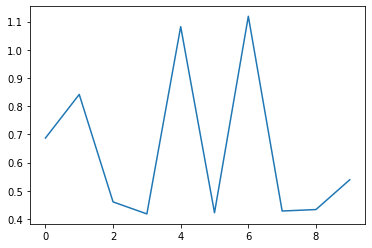

In [18]:
plt.plot(loss_array)
plt.show()